# Image classification notebook: a tool paired with "Automated determination of transport and depositional environments in sand and sandstones"
##by Michael Hasson, M. Colin Marvin, and Mathieu Lapotre

This notebook can be used to classify SEM images of grains of quartz sand based on their depositional or transport environment. Please see our paper for a full explanation.

To make predictions, all you need to do is hit shift+enter on each cell (or click the play buttons). Please see detailed instructions for more specific configuration.

Run the cell below to obtain all necessary files for classification.

In [1]:
!git clone https://github.com/michaelhasson/SandAI.git
%cd SandAI

fatal: destination path 'microtextures' already exists and is not an empty directory.
/content/microtextures


Before you use this software, it is essential to make sure that your images meet the criteria necessary to get valid predictions. Please use the checklist below, and only proceed if your images meet these criteria! (Checklist is identical to the one in the Github Readme).

## Checklist

Before using the model, it is critical to make that images are suitable for model inference. Failure to do so will lead to inaccurate results. The requirements are:
1. Sand must be from terrestrial environments (eolian, glacial, beach, or fluvial).
2. No scale bars.
3. Individual grains only -- there can only be one sand grain per image.
4. The original grain shapes and textures must be present. If they have been obscured by diagenesis (e.g., silica cementation) or the sample preparation procedure, they will not produce valid results.

### Visual checklist examples:
Make sure that your images *do not* look like these before using the classifier!

1. Do your images contain scale bars?

<table>
  <tr>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Scale_bars/scale_bar.png?raw=true" width="375" height="300"></td>
  </tr>
</table>

2. Is there only one grain per image?

<table>
  <tr>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Multiple_grains/FF01i_0074_annotated.png?raw=true" width="375" height="300"></td>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Multiple_grains/a16-64455-thin_0037_annotated.png?raw=true" width="375" height="300"></td>
  </tr>
</table>

3. Are the grain surfaces obscured by diagenesis?

<table>
  <tr>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Overgrowth/Dino_cyn_5_postHCl_10_13_23_0003_annotated.png?raw=true" width="375" height="300"></td>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Overgrowth/Dino_cyn_5_postHCl_10_13_23_0004_annotated.png?raw=true" width="375" height="300"></td>
  </tr>
</table>

4. Are the grain surfaces obscured by the sample preparation procedure?

<table>
  <tr>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Coatings/4_annotated.png?raw=true" width="375" height="300"></td>
    <td><img src="https://github.com/michaelhasson/microtextures/blob/main/Checklist_images/Coatings/91_annotated.png?raw=true" width="375" height="300"></td>
  </tr>
</table>

## Import block: reads in the necessary dependencies to run the DNN.

In [1]:
import os
import torch
from torch.utils.data import DataLoader
from utils import *
import urllib
import gdown

c:\Users\mhasson\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\mhasson\Anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback

## Set the paths to your image folder and where you want the CSV file of results to be exported

This will work as-is for the demonstration files provided. For your own images, simply upload them to session storage.

To upload: First, click the file icon in the left-hand toolbar, then click the three dots that appear when mousing over the "Microtextures" folder. Create a new folder with your sample name. Once the folder is created, drag and drop images from your local computer into this folder. In the "sample" field below, type the name of the folder to make inferences on those images. The CSV will automatically be named to correspond with the sample name and saved in a folder called "Predictions".

In [4]:
sample = 'MT101_3_15_24'
data_path = f"/content/microtextures/{sample}"

os.makedirs('/content/microtextures/predictions/', exist_ok=True)
csv_path = f"/content/microtextures/predictions/{sample}.csv"

# confidence_threshold = 0.25

## Download the model weights from Google drive

In [5]:
url = 'https://drive.google.com/uc?export=download&id=1y6Ana6E-J4jjpc5r2K9fsyu7quA8bXZs'

model_path = 'qtz_final_model.pth'
gdown.download(url, model_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1y6Ana6E-J4jjpc5r2K9fsyu7quA8bXZs
From (redirected): https://drive.google.com/uc?export=download&id=1y6Ana6E-J4jjpc5r2K9fsyu7quA8bXZs&confirm=t&uuid=1fbe5bb6-2254-4568-9ef5-6019094e3205
To: /content/microtextures/qtz_final_model.pth
100%|██████████| 283M/283M [00:02<00:00, 131MB/s]


'qtz_final_model.pth'

## Display example images to confirm that the notebook has read them correctly, and make inferences of image classes. (This may take a few minutes -- when it's done, a message will print stating where the CSV was saved)

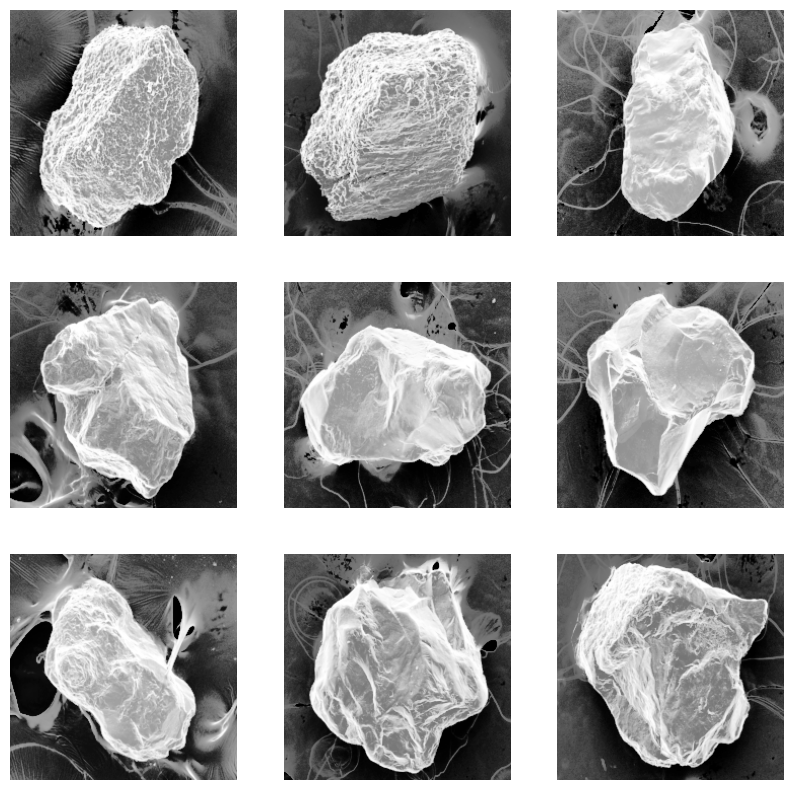

Predicting on sample MT101_3_15_24
Saved CSV at: /content/microtextures/predictions/MT101_3_15_24.csv


In [6]:
# Gather image paths
paths = []
for subdir, dirs, files in os.walk(data_path):
    for file in files:
        filepath = subdir + os.sep + file
        paths.append(filepath)

# Create the dataset and dataloader
imagedataset = CustomDataset(paths, transform=transform)
imagedl = DataLoader(imagedataset, batch_size=1, drop_last=False)

# Display random images
display_random_images(imagedataset)

# Make predictions! The default confidence threshold is 0.75. If you want to change the threshold, simply add it as an input argument after csv_path.
# It should look like: confidence_threshold=0.5. If you don't specify, the default will be used automatically.
make_predictions(sample, imagedataset, imagedl, model_path, csv_path)


## Download your results by navigating to the "Predictions" folder and clicking the "Download" button for each sample. 